In [44]:
import torch
from models import prepare_mnist, prepare_fashion_mnist

import numpy as np
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
writer = SummaryWriter()
from models import MNISTConf

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1078, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/home/shinzato/venv/lib/python3.8/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 1976, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/home/shinzato/venv/lib/python3.8/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2011, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 

In [46]:
import json
import dataclasses
conf = MNISTConf(batch_size=128, n_hid=100, n_vis=784, lr=0.01, n_epoch=10, optimizer="")

In [47]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
conf.device = device
print("device:", device)


device: cuda


In [48]:
train_datasets, train_loader, test_datasets, test_loader = prepare_fashion_mnist(batch_size=conf.batch_size)

(60000, 784)

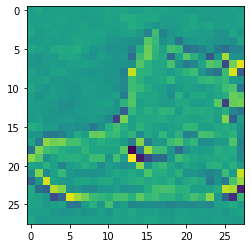

In [56]:
def zca_whitening_matrix(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [N x M] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X.T, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-10
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

data = train_datasets.data.view(-1, conf.n_vis).numpy()
P = zca_whitening_matrix(data)
import matplotlib.pyplot as plt

plt.imshow(data[0].reshape(28, 28))

plt.imshow(np.dot(data, P).reshape((-1, 28, 28))[0])
data_white = np.dot(data, P).reshape((-1, conf.n_vis))
data_white.shape

In [42]:
from models import AutoEncoder, RBM, MLPAutoEncoder, VAE

def generate_vv(model, conf, fast=False):
    for epoch in tqdm(range(conf.n_epoch)):
        vv = np.zeros((len(train_datasets), conf.n_hid))
        if fast:
            for idx, (data, target) in enumerate(train_loader):
                batch_size = data.size(0)
                n_iter = len(train_loader) * epoch + idx
                recon_loss = model.train_step(data.to(conf.device)).to("cpu")
                writer.add_scalar(f"{model.__class__.__name__}/{str(conf)}/recon_loss", recon_loss, n_iter)
                vv[idx*batch_size:(idx+1)*batch_size, :] = model.encode(data.view(-1, conf.n_vis).to(conf.device)).detach().cpu().numpy()
        else:
            for idx, (data, target) in enumerate(train_loader):
                if conf.whitening_vis:
                    batch_size = data.size(0)
                    n_iter = len(train_loader) * epoch
                    batch_white = np.dot(data.view(batch_size, -1).numpy(), P)
                    batch_white = torch.from_numpy(batch_white.astype(np.float32)).clone().view(batch_size, -1)
                    vv[idx*batch_size:(idx+1)*batch_size, :] = model.encode(batch_white.to(conf.device)).detach().cpu().numpy()
                    
                else:
                    batch_size = data.size(0)
                    n_iter = len(train_loader) * epoch
                    vv[idx*batch_size:(idx+1)*batch_size, :] = model.encode(data.view(-1, conf.n_vis).to(conf.device)).detach().cpu().numpy()
            for idx, (data, target) in enumerate(train_loader):
                if conf.whitening_learn:
                    batch_size = data.size(0)
                    n_step = len(train_loader) * epoch + idx
                    batch_white = np.dot(data.view(batch_size, -1).numpy(), P)
                    batch_white = torch.from_numpy(batch_white.astype(np.float32)).clone().view(batch_size, -1)
                    loss = model.train_step(batch_white.to(conf.device)).cpu()
                    writer.add_scalar(f"{model.__class__.__name__}/{str(conf)}/loss", loss, n_step)
                    recon_loss = model.recon_loss(batch_white.to(device)).cpu()
                    writer.add_scalar(f"{model.__class__.__name__}/{str(conf)}/recon_loss", recon_loss, n_step)  


                else:
                    batch_size = data.size(0)
                    n_step = len(train_loader) * epoch + idx
                    loss = model.train_step(data.to(device)).cpu()
                    writer.add_scalar(f"{model.__class__.__name__}/{str(conf)}/loss", loss, n_step)
                    recon_loss = model.recon_loss(data.to(device)).cpu()
                    writer.add_scalar(f"{model.__class__.__name__}/{str(conf)}/recon_loss", recon_loss, n_step)                
        yield epoch, n_iter, vv
    
model = RBM(conf).to(device)
vv_iter = generate_vv(model, conf)

  0%|          | 0/10 [00:12<?, ?it/s]


KeyboardInterrupt: 

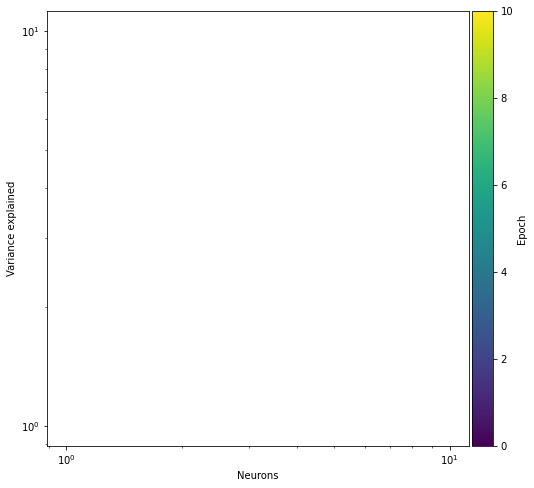

In [43]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

if not conf.whitening_learn:
    sample_images = next(iter(test_loader))[0]
else:
    sample_images = next(iter(test_loader))[0]
    sample_images = np.dot(sample_images.numpy().reshape(-1, conf.n_vis), P)
    sample_images = torch.from_numpy(sample_images.astype(np.float32)).clone()


sample_img = make_grid(sample_images.view(conf.batch_size, 1, 28, 28).data)

fig, ax = plt.subplots(figsize=(8, 8))
divider = make_axes_locatable(ax)
mappable = cm.ScalarMappable(cmap=cm.viridis, norm=matplotlib.colors.Normalize(vmin=0, vmax=conf.n_epoch))
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mappable=mappable,cax=cax, label="Epoch")


xx = np.arange(conf.n_hid) + 1
log_xx = np.log(xx)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('Neurons')
ax.set_ylabel('Variance explained')

for n_epoch, n_iter, vv in vv_iter:

    pca = PCA()
    pca.fit(vv)
    yy = pca.explained_variance_
    log_yy = np.log(yy)
    m, c = np.linalg.lstsq(np.vstack([log_xx, np.ones(len(log_xx))]).T, log_yy, rcond=None)[0]
    pcm = ax.plot(xx, yy, '.-', label=f"epoch: {n_epoch}, m: {m:.3}", color=cm.viridis(n_epoch / conf.n_epoch))
    # ax.legend()
    ax.grid(visible=True)
    writer.add_figure(f"{model.__class__.__name__}/{str(conf)}/neuron_fireings", fig, global_step=n_iter)

    v_recon = model(sample_images.view(conf.batch_size, -1).to(device))
    sample_recon = make_grid(v_recon.view(conf.batch_size, 1, 28, 28).data).cpu()
    writer.add_image(f"{model.__class__.__name__}/{str(conf)}/sample_input", sample_img, global_step=n_iter)
    writer.add_image(f"{model.__class__.__name__}/{str(conf)}/sample_recon", sample_recon, global_step=n_iter)
#ax.legend()
#fig.colorbar(ax)
ax.grid(visible=True)
writer.add_figure(f"{model.__class__.__name__}/{str(conf)}/neuron_fireings", fig, close=True)


In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
xx = np.arange(conf.n_hid) + 1
log_xx = np.log(xx)

ax.set_xlabel('Neurons')
ax.set_ylabel('Variance explained')
ax.set_yscale("log")
ax.set_xscale("log")
pca = PCA()
pca.fit(vv)
yy = pca.explained_variance_
log_yy = np.log(yy)
m, c = np.linalg.lstsq(np.vstack([log_xx, np.ones(len(log_xx))]).T, log_yy, rcond=None)[0]
ax.plot(xx, yy,'.-', label=f"epoch: {conf.n_epoch}")
ax.plot(xx, np.e**c * xx**m, label=f"log y= {m:.3} log x + {c:.3}")
ax.legend()
ax.grid(visible=True)
writer.add_figure(f"{model.__class__.__name__}/{str(conf)}/result/log", fig)


In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
xx = np.arange(conf.n_hid) + 1
log_xx = np.log(xx)

ax.set_xlabel('Neurons')
ax.set_ylabel('Variance explained')
pca = PCA()
pca.fit(vv)
yy = pca.explained_variance_
log_yy = np.log(yy)
m, c = np.linalg.lstsq(np.vstack([log_xx, np.ones(len(log_xx))]).T, log_yy, rcond=None)[0]
ax.plot(xx, yy,'.-', label=f"epoch: {conf.n_epoch}")
ax.plot(xx, np.e**c * xx**m, label=f"log y= {m:.3} log x + {c:.3}")
ax.legend()
ax.set_ylim(0, np.max(yy))
ax.grid(visible=True)
writer.add_figure(f"{model.__class__.__name__}/{str(conf)}/result/nonlog", fig)

In [ ]:
import plfit

myplfit = plfit.plfit(yy)


PYTHON plfit executed in 0.007788 seconds
xmin: 0.0011651 n(>xmin): 81 alpha: 1.57636 +/- 0.0640394   Log-Likelihood: 280.979   ks: 0.0496718 p(ks): 0.64927


/home/shinzato/venv/lib/python3.8/site-packages/plfit/plfit.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  a = 1+float(n) / sum(log(x/xmin))


<AxesSubplot:xlabel='$\\alpha$', ylabel='KS statistic'>

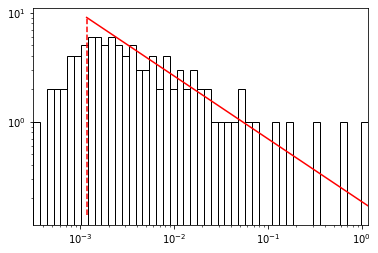

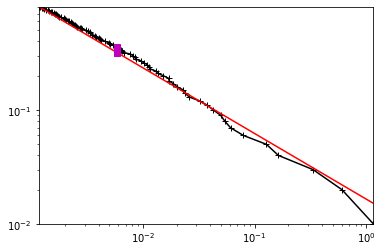

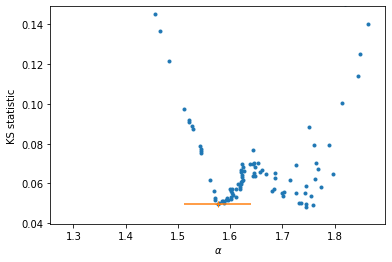

In [ ]:
# generate some plots
from pylab import *
figure(1)
myplfit.plotpdf()

figure(2)
myplfit.plotcdf()

figure(3)
myplfit.alphavsks()

In [ ]:

vv = np.zeros((len(test_datasets), conf.n_hid))
vvlabel = np.zeros(len(test_datasets), dtype=np.int32)
dataimg = np.zeros((len(test_datasets), conf.n_vis))

for idx, (data, target) in enumerate(test_loader):
    batch_size = data.size(0)
    vv[idx*batch_size:(idx+1)*batch_size, :] = model.encode(data.view(-1, conf.n_vis).to(device)).detach().cpu().numpy()
    vvlabel[idx*batch_size:(idx+1)*batch_size] = target
    dataimg[idx*batch_size:(idx+1)*batch_size, :] = data.view(batch_size, -1)

dataimg = torch.from_numpy(dataimg.reshape(-1, 1, 28, 28))

In [ ]:
writer.add_embedding(vv, metadata=vvlabel, label_img=dataimg, tag=f"{model.__class__.__name__}/{str(conf)}/projector")

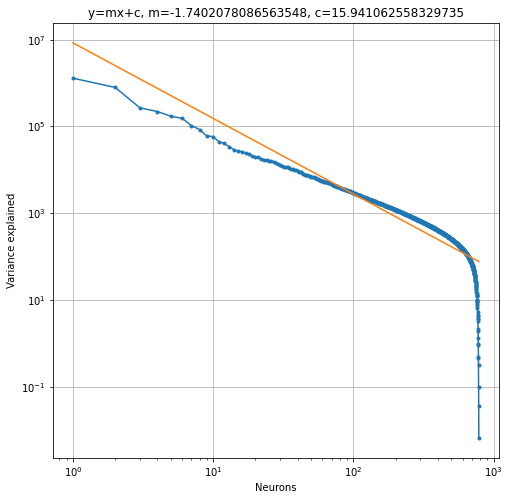

In [54]:
import sklearn
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(train_datasets.data.view(-1, 784).numpy())

fig, ax = plt.subplots(figsize=(8, 8))
xx = np.arange(len(pca.explained_variance_)) + 1
ax.plot(xx, pca.explained_variance_, '.-')


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Neurons')
ax.set_ylabel('Variance explained')
log_xx = np.log(xx)
yy = pca.explained_variance_
log_yy = np.log(yy)
m, c = np.linalg.lstsq(np.vstack([log_xx, np.ones(len(log_xx))]).T, log_yy, rcond=None)[0]
ax.set_title(f'y=mx+c, m={m}, c={c}')
ax.plot(xx, np.e**c * xx**m, label=f"log y= {m:.3} log x + {c:.3}")
ax.grid()
#ax.set_ylim(10 ** (-10))

/home/shinzato/venv/lib/python3.8/site-packages/plfit/plfit.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  a = 1+float(n) / sum(log(x/xmin))


PYTHON plfit executed in 0.049877 seconds
xmin: 1273.59 n(>xmin): 192 alpha: 1.80252 +/- 0.0579172   Log-Likelihood: -1846.21   ks: 0.0145521 p(ks): 0.913078


<AxesSubplot:xlabel='$\\alpha$', ylabel='KS statistic'>

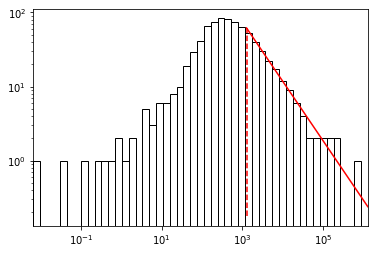

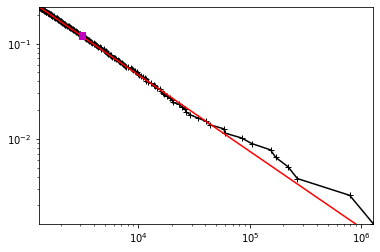

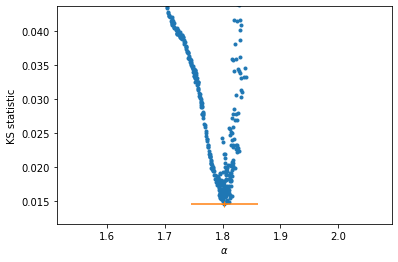

In [55]:
import plfit

myplfit = plfit.plfit(yy)
from pylab import *
figure(1)
myplfit.plotpdf()

figure(2)
myplfit.plotcdf()

figure(3)
myplfit.alphavsks()

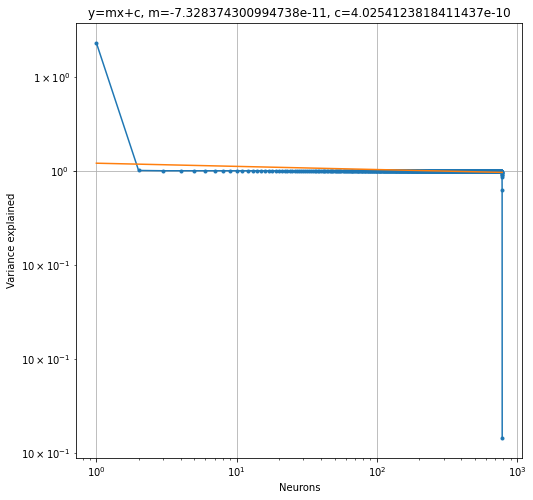

In [57]:
import sklearn
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(data_white)

fig, ax = plt.subplots(figsize=(8, 8))
xx = np.arange(len(pca.explained_variance_)) + 1
ax.plot(xx, pca.explained_variance_, '.-')


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Neurons')
ax.set_ylabel('Variance explained')
log_xx = np.log(xx)
yy = pca.explained_variance_
log_yy = np.log(yy)
m, c = np.linalg.lstsq(np.vstack([log_xx, np.ones(len(log_xx))]).T, log_yy, rcond=None)[0]
ax.set_title(f'y=mx+c, m={m}, c={c}')
ax.plot(xx, np.e**c * xx**m, label=f"log y= {m:.3} log x + {c:.3}")
ax.grid()